In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
import itertools


In [2]:
def gatling_log_parse(path: str) -> pd.DataFrame:
    # CSVから読み取る
    try:
        df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])
    except Exception as e:
        raise(e)
    df_target = df.to_numpy()

    # いい感じに整形
    requests = pd.DataFrame([{"date": datetime.fromtimestamp(float(d[4])/1000), "status": d[6], "count": 1} for d in df_target if (d[0] == "REQUEST" and not math.isnan(float(d[4])) )])
    if len(requests) == 0:
        return pd.DataFrame([])

    # 1秒ごとにサマる
    grouped1 = requests.groupby([pd.Grouper(key=("status")),pd.Grouper(key=("date"), freq="S")]).sum().reset_index()

    # 全部同じ数は困るので乱数を入れておく
    for x in range(len(grouped1)):
        grouped1.iat[x, 2] += np.random.rand() * sys.float_info.epsilon

    return grouped1

In [129]:
simulation_log_01 = gatling_log_parse("simulation.log")

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3851805739.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [6]:
simulation_log_date_01  = simulation_log_01["date"]
simulation_log_count_01 = simulation_log_01["count"]

In [131]:
pred_01 = pd.read_csv("pred_20220718120600.log", names=["index", "date", "max_pred_df_count", "pred_fuzzy", "pred_sample", "pred_fuzzy_300",  "pred_sample_300", "pred_pairwise"])
pred_01

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18T12:06:30.694938,18.517932,1.552555,1.386294,NaN,NaN,-0.121530
1,0,2022-07-18T12:07:00.717071,22.125286,1.603756,2.197225,NaN,NaN,0.158622
2,0,2022-07-18T12:07:30.702381,22.242095,1.639308,1.832581,NaN,NaN,0.153210
3,0,2022-07-18T12:08:00.723084,20.041667,1.608362,2.079442,NaN,NaN,-0.003312
4,0,2022-07-18T12:08:30.707103,22.808088,1.573876,1.845827,NaN,NaN,0.128233
5,0,2022-07-18T12:09:00.735242,49.181230,1.026570,1.468211,NaN,NaN,0.732982
6,0,2022-07-18T12:09:30.761900,99.772912,0.663783,1.016639,NaN,NaN,0.919359
7,0,2022-07-18T12:10:00.779043,144.680842,0.647976,0.997516,NaN,NaN,0.963697
8,0,2022-07-18T12:10:30.823166,176.674780,0.790734,0.953105,NaN,NaN,0.937334
9,0,2022-07-18T12:11:00.837192,209.337827,0.888360,1.285824,NaN,NaN,0.916167


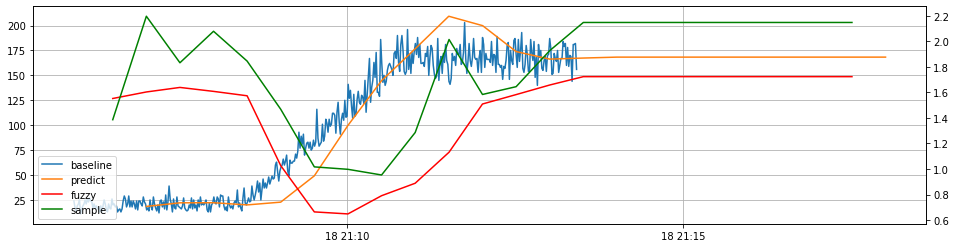

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(simulation_log_date_01, simulation_log_count_01,label='baseline')
ln1 = axes.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) + timedelta(seconds=30) for date_str in  pred_01["date"]], pred_01["max_pred_df_count"].apply(lambda x: 0 if x < 0 else x ),label='predict')

ax1 = axes.twinx()
ln2 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_01["date"]], pred_01["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_01["date"]], pred_01["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

In [134]:
simulation_log_02 = gatling_log_parse("simulation_02.log")
simulation_log_date_02  = simulation_log_02["date"]
simulation_log_count_02 = simulation_log_02["count"]

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3851805739.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [135]:
pred_02 = pd.read_csv("pred_20220718125226.log", names=["index", "date", "max_pred_df_count", "pred_fuzzy", "pred_sample", "pred_fuzzy_300",  "pred_sample_300", "pred_pairwise"])
pred_02

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18T12:52:26.331680,59.000000,1.666667,-inf,NaN,NaN,0.946729
1,0,2022-07-18T12:52:56.360610,21.368511,1.751948,inf,NaN,NaN,-0.014681
2,0,2022-07-18T12:53:26.359121,20.398298,1.734495,inf,NaN,NaN,-0.046612
3,0,2022-07-18T12:53:56.343487,19.766427,1.690061,inf,NaN,NaN,-0.093412
4,0,2022-07-18T12:54:26.353933,19.852165,1.596517,1.897120,NaN,NaN,0.009753
5,0,2022-07-18T12:54:56.361803,21.395065,1.509983,2.484907,NaN,NaN,0.097914
6,0,2022-07-18T12:55:26.397111,84.314174,0.529242,0.525626,NaN,NaN,0.803371
7,0,2022-07-18T12:55:56.421880,183.532753,0.377661,0.301668,NaN,NaN,0.960503
8,0,2022-07-18T12:56:26.464519,268.551073,0.426059,0.619039,NaN,NaN,0.987780
9,0,2022-07-18T12:56:56.524931,336.953022,0.532478,0.870828,NaN,NaN,0.978824


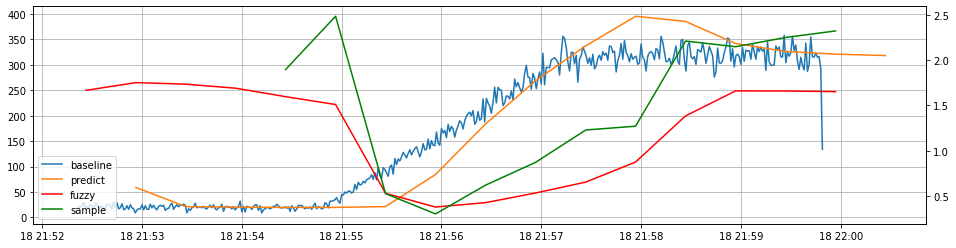

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(simulation_log_date_02, simulation_log_count_02,label='baseline')
ln1 = axes.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) + timedelta(seconds=30) for date_str in  pred_02["date"]], pred_02["max_pred_df_count"].apply(lambda x: 0 if x < 0 else x ),label='predict')

ax1 = axes.twinx()
ln2 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_02["date"]], pred_02["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_02["date"]], pred_02["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

In [166]:
simulation_log_03 = gatling_log_parse("simulation_03.log")
simulation_log_date_03  = simulation_log_03["date"]
simulation_log_count_03 = simulation_log_03["count"]

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3851805739.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [167]:
pred_03 = pd.read_csv("pred_20220718130949.log", names=["index", "date", "max_pred_df_count", "pred_fuzzy", "pred_sample", "pred_fuzzy_300",  "pred_sample_300", "pred_pairwise"])
pred_03

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18T13:09:49.518691,23.000000,6.770167,-inf,NaN,NaN,0.027735
1,0,2022-07-18T13:10:19.550555,18.348077,1.652060,-inf,NaN,NaN,-0.145295
2,0,2022-07-18T13:10:49.547064,18.918625,1.670117,inf,NaN,NaN,-0.061211
3,0,2022-07-18T13:11:19.562955,19.854307,1.628426,2.944439,NaN,NaN,0.032234
4,0,2022-07-18T13:11:49.566457,22.451088,1.622697,inf,NaN,NaN,0.210964
5,0,2022-07-18T13:12:19.569844,21.828641,1.613139,3.135494,NaN,NaN,0.121879
6,0,2022-07-18T13:12:49.563577,34.976873,1.217835,1.448815,NaN,NaN,0.603449
7,0,2022-07-18T13:13:19.587089,62.243364,0.842357,1.236763,NaN,NaN,0.866721
8,0,2022-07-18T13:13:49.604554,82.710932,0.871816,1.114361,NaN,NaN,0.911493
9,0,2022-07-18T13:14:19.618074,95.815823,1.088333,1.116961,NaN,NaN,0.874319


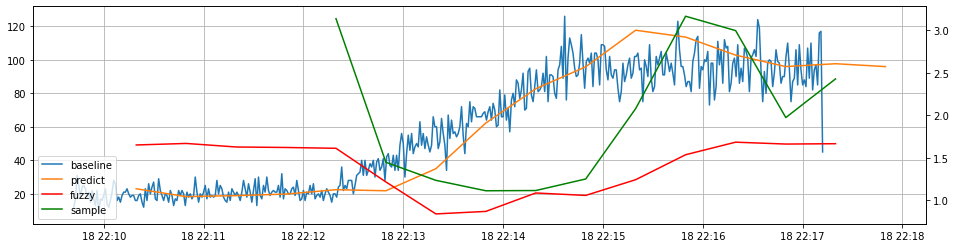

In [168]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(simulation_log_date_03, simulation_log_count_03,label='baseline')
ln1 = axes.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) + timedelta(seconds=30) for date_str in  pred_03["date"]], pred_03["max_pred_df_count"].apply(lambda x: 0 if x < 0 else x ),label='predict')

ax1 = axes.twinx()
ln2 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_03[1:]["date"]], pred_03[1:]["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_03["date"]], pred_03["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

In [3]:
simulation_log_04 = gatling_log_parse("simulation_04.log")
simulation_log_date_04  = simulation_log_04["date"]
simulation_log_count_04 = simulation_log_04["count"]

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3851805739.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [36]:
simulation_log_date_04

0     2022-07-18 23:27:51
1     2022-07-18 23:27:52
2     2022-07-18 23:27:53
3     2022-07-18 23:27:54
4     2022-07-18 23:27:55
              ...        
446   2022-07-18 23:35:17
447   2022-07-18 23:35:18
448   2022-07-18 23:35:19
449   2022-07-18 23:35:20
450   2022-07-18 23:35:21
Name: date, Length: 451, dtype: datetime64[ns]

In [4]:
pred_04 = pd.read_csv("pred_20220718142755.log", names=["index", "date", "max_pred_df_count", "pred_fuzzy", "pred_sample", "pred_fuzzy_300",  "pred_sample_300", "pred_pairwise"])
pred_04

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18T14:28:25.342911,20.096774,2.003899,inf,NaN,NaN,-0.006632
1,0,2022-07-18T14:28:55.355040,20.145161,1.707158,inf,NaN,NaN,-0.005864
2,0,2022-07-18T14:29:25.331858,19.139422,1.674627,2.995732,NaN,NaN,-0.092061
3,0,2022-07-18T14:29:55.359276,18.969506,1.625921,3.258097,NaN,NaN,-0.092789
4,0,2022-07-18T14:30:25.362361,22.787019,1.501177,3.610918,NaN,NaN,0.217511
5,0,2022-07-18T14:30:55.428570,130.316442,0.402146,0.329753,NaN,NaN,0.783482
6,0,2022-07-18T14:31:25.429056,333.432726,0.305032,0.105654,NaN,NaN,0.954092
7,0,2022-07-18T14:31:55.630676,507.312066,0.328579,0.395896,NaN,NaN,0.993017
8,0,2022-07-18T14:32:25.591075,623.533393,0.440476,0.688281,NaN,NaN,0.986241
9,0,2022-07-18T14:32:55.698280,756.241998,0.515503,0.730091,NaN,NaN,0.982280


In [148]:
pred_04["date"] = pd.to_datetime(pred_04["date"])
pred_04_S = pred_04.groupby(pd.Grouper(key=("date"), freq="S")).mean().dropna(how='all').reset_index()
pred_04_S

,date,index,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,2022-07-18 14:28:25,0.0,20.096774,2.003899,inf,NaN,NaN,-0.006632
1,2022-07-18 14:28:55,0.0,20.145161,1.707158,inf,NaN,NaN,-0.005864
2,2022-07-18 14:29:25,0.0,19.139422,1.674627,2.995732,NaN,NaN,-0.092061
3,2022-07-18 14:29:55,0.0,18.969506,1.625921,3.258097,NaN,NaN,-0.092789
4,2022-07-18 14:30:25,0.0,22.787019,1.501177,3.610918,NaN,NaN,0.217511
5,2022-07-18 14:30:55,0.0,130.316442,0.402146,0.329753,NaN,NaN,0.783482
6,2022-07-18 14:31:25,0.0,333.432726,0.305032,0.105654,NaN,NaN,0.954092
7,2022-07-18 14:31:55,0.0,507.312066,0.328579,0.395896,NaN,NaN,0.993017
8,2022-07-18 14:32:25,0.0,623.533393,0.440476,0.688281,NaN,NaN,0.986241
9,2022-07-18 14:32:55,0.0,756.241998,0.515503,0.730091,NaN,NaN,0.982280


In [151]:
datetime.fromisoformat("2022-07-18 14:28:25.342911")

datetime.datetime(2022, 7, 18, 14, 28, 25, 342911)

TypeError: fromisoformat: argument must be str

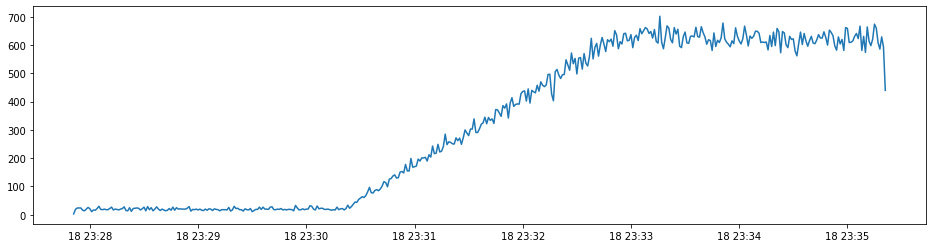

In [149]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(simulation_log_date_04, simulation_log_count_04,label='baseline')
ln1 = axes.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) + timedelta(seconds=30) for date_str in  pred_04["date"]], pred_04["max_pred_df_count"].apply(lambda x: 0 if x < 0 else x ),label='predict')

ax1 = axes.twinx()
ln2 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_04[1:]["date"]], pred_04[1:]["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([datetime.fromisoformat(date_str) + timedelta(hours=9) for date_str in  pred_04["date"]], pred_04["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

In [29]:
pred_04["date"] = pd.to_datetime(pred_04["date"])
pred_04_S = pred_04.groupby(pd.Grouper(key=("date"), freq="S")).mean().dropna(how='all').reset_index()
pred_04_S

,date,index,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,2022-07-18 14:28:25,0.0,20.096774,2.003899,inf,NaN,NaN,-0.006632
1,2022-07-18 14:28:55,0.0,20.145161,1.707158,inf,NaN,NaN,-0.005864
2,2022-07-18 14:29:25,0.0,19.139422,1.674627,2.995732,NaN,NaN,-0.092061
3,2022-07-18 14:29:55,0.0,18.969506,1.625921,3.258097,NaN,NaN,-0.092789
4,2022-07-18 14:30:25,0.0,22.787019,1.501177,3.610918,NaN,NaN,0.217511
5,2022-07-18 14:30:55,0.0,130.316442,0.402146,0.329753,NaN,NaN,0.783482
6,2022-07-18 14:31:25,0.0,333.432726,0.305032,0.105654,NaN,NaN,0.954092
7,2022-07-18 14:31:55,0.0,507.312066,0.328579,0.395896,NaN,NaN,0.993017
8,2022-07-18 14:32:25,0.0,623.533393,0.440476,0.688281,NaN,NaN,0.986241
9,2022-07-18 14:32:55,0.0,756.241998,0.515503,0.730091,NaN,NaN,0.982280


In [30]:
pred_04_S["date"]

0    2022-07-18 14:28:25
1    2022-07-18 14:28:55
2    2022-07-18 14:29:25
3    2022-07-18 14:29:55
4    2022-07-18 14:30:25
5    2022-07-18 14:30:55
6    2022-07-18 14:31:25
7    2022-07-18 14:31:55
8    2022-07-18 14:32:25
9    2022-07-18 14:32:55
10   2022-07-18 14:33:25
11   2022-07-18 14:33:55
12   2022-07-18 14:34:26
13   2022-07-18 14:34:56
14   2022-07-18 14:35:26
15   2022-07-18 14:35:56
16   2022-07-18 14:36:26
17   2022-07-18 14:36:56
18   2022-07-18 14:37:26
19   2022-07-18 14:37:56
20   2022-07-18 14:38:26
Name: date, dtype: datetime64[ns]

In [55]:
[simulation_log_04.loc[simulation_log_04["date"] == x + timedelta(hours=9) + timedelta(seconds=30)] for x in
     pred_04_S["date"]]

[   status                date  count
 64     OK 2022-07-18 23:28:55     29,
    status                date  count
 94     OK 2022-07-18 23:29:25     13,
     status                date  count
 124     OK 2022-07-18 23:29:55     24,
     status                date  count
 154     OK 2022-07-18 23:30:25     29,
     status                date  count
 184     OK 2022-07-18 23:30:55    178,
     status                date  count
 214     OK 2022-07-18 23:31:25    271,
     status                date  count
 244     OK 2022-07-18 23:31:55    383,
     status                date  count
 274     OK 2022-07-18 23:32:25    530,
     status                date  count
 304     OK 2022-07-18 23:32:55    604,
     status                date  count
 334     OK 2022-07-18 23:33:25    639,
     status                date  count
 364     OK 2022-07-18 23:33:55    594,
     status                date  count
 394     OK 2022-07-18 23:34:25    643,
     status                date  count
 425     OK 2022-

In [83]:
simulation_log_04_at_pred = pd.DataFrame()
for d in pred_04_S["date"]:
    simulation_log_04_at_pred = simulation_log_04_at_pred.append(simulation_log_04.loc[simulation_log_04["date"] == d + timedelta(hours=9) + timedelta(seconds=30)])

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/1304135452.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation_log_04_at_pred = simulation_log_04_at_pred.append(simulation_log_04.loc[simulation_log_04["date"] == d + timedelta(hours=9) + timedelta(seconds=30)])
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/1304135452.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation_log_04_at_pred = simulation_log_04_at_pred.append(simulation_log_04.loc[simulation_log_04["date"] == d + timedelta(hours=9) + timedelta(seconds=30)])
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/1304135452.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation_log_04_at_pred =

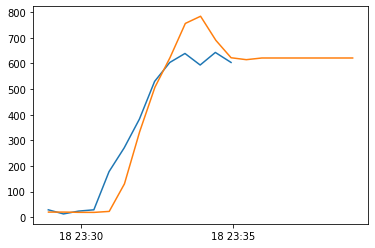

In [84]:
plt.plot(simulation_log_04_at_pred["date"], simulation_log_04_at_pred["count"])
plt.plot([d + timedelta(hours=9) + timedelta(seconds=30) for d in  pred_04["date"]], pred_04_S["max_pred_df_count"])

In [116]:

simulation_log_04_diff = []
for d in pred_04_S["date"]:
    try:
        simulation_log_04_actual = simulation_log_04.loc[simulation_log_04["date"] == d + timedelta(hours=9) + timedelta(seconds=30)]["count"].values[0]
        simulation_log_04_pred = pred_04_S.loc[pred_04_S["date"] == d]["max_pred_df_count"].values[0]
        simulation_log_04_diff.append(simulation_log_04_pred - simulation_log_04_actual)
    except:
        continue

In [117]:
simulation_log_04_diff

[-8.903225806451612,
 7.14516129032258,
 -4.860577866435051,
 -10.030494254082441,
 -155.2129807844758,
 -140.68355751037598,
 -49.56727409362793,
 -22.687933921813908,
 19.533392906188965,
 117.24199771881104,
 190.28829288482666,
 47.272430658340454,
 18.33402243256569]

In [144]:
def enet_pred_diff(simulation_log: pd.DataFrame, pred: pd.DataFrame) -> pd.DataFrame:
    pred["date"] = pd.to_datetime(pred["date"])
    pred_S = pred.groupby(pd.Grouper(key=("date"), freq="S")).mean().dropna(how='all').reset_index()
    diff = pd.DataFrame()
    for d in pred_S["date"]:
        try:
            actual = simulation_log.loc[simulation_log["date"] == d + timedelta(hours=9) + timedelta(seconds=30)]["count"].values[0]
            pred_value = pred_S.loc[pred_S["date"] == d]["max_pred_df_count"].values[0]
            diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
        except:
            continue
    return diff

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame

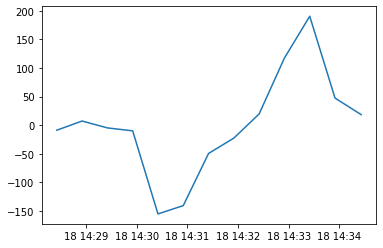

In [146]:
enet_pred_diff_04 = enet_pred_diff(simulation_log_04, pred_04)
plt.plot(enet_pred_diff_04["date"], enet_pred_diff_04["count"])

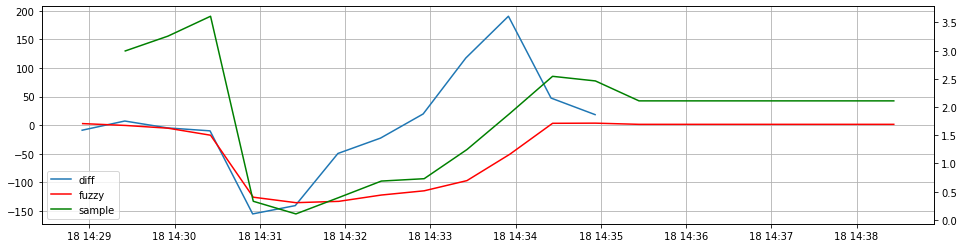

In [155]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(enet_pred_diff_04["date"] + timedelta(seconds=30), enet_pred_diff_04["count"],label='diff')

ax1 = axes.twinx()
ln2 = ax1.plot([date for date in  pred_04[1:]["date"]], pred_04[1:]["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([date for date in  pred_04["date"]], pred_04["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

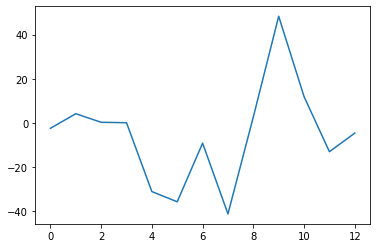

In [132]:
plt.plot(enet_pred_diff(simulation_log_01, pred_01))

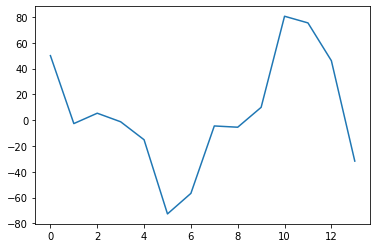

In [138]:
plt.plot(enet_pred_diff(simulation_log_02, pred_02))


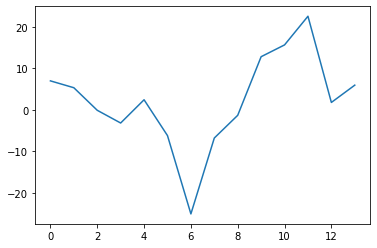

In [139]:
plt.plot(enet_pred_diff(simulation_log_03, pred_03))


/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame

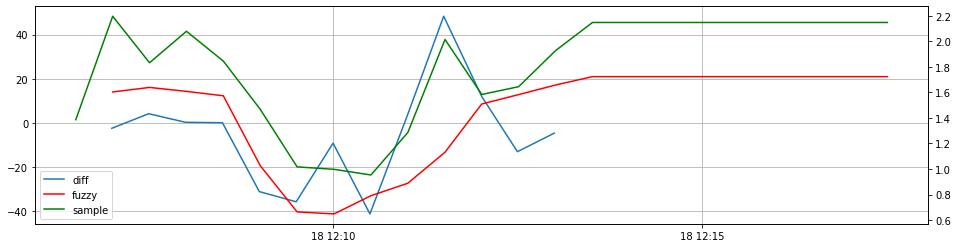

In [156]:
enet_pred_diff_01 = enet_pred_diff(simulation_log_01, pred_01)
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(enet_pred_diff_01["date"] + timedelta(seconds=30), enet_pred_diff_01["count"],label='diff')

ax1 = axes.twinx()
ln2 = ax1.plot([date for date in  pred_01[1:]["date"]], pred_01[1:]["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([date for date in  pred_01["date"]], pred_01["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame

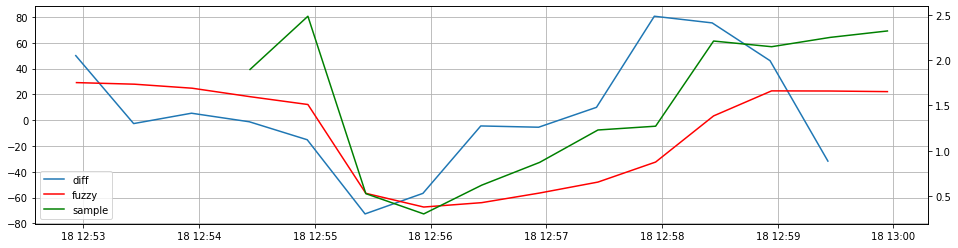

In [157]:
enet_pred_diff_02 = enet_pred_diff(simulation_log_02, pred_02)
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(enet_pred_diff_02["date"] + timedelta(seconds=30), enet_pred_diff_02["count"],label='diff')

ax1 = axes.twinx()
ln2 = ax1.plot([date for date in  pred_02[1:]["date"]], pred_02[1:]["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([date for date in  pred_02["date"]], pred_02["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame

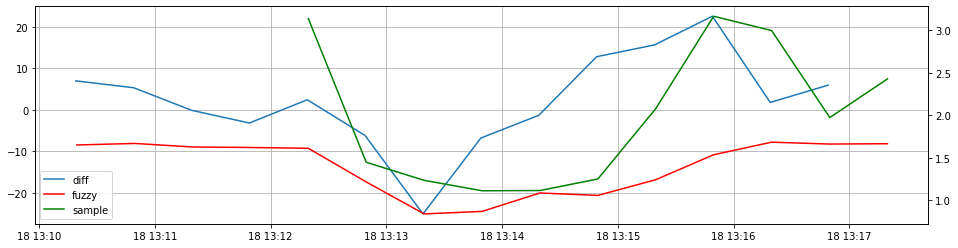

In [172]:
enet_pred_diff_03 = enet_pred_diff(simulation_log_03, pred_03)
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(enet_pred_diff_03["date"] + timedelta(seconds=30), enet_pred_diff_03["count"],label='diff')

ax1 = axes.twinx()
ln2 = ax1.plot([date for date in  pred_03[1:]["date"]], pred_03[1:]["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([date for date in  pred_03["date"]], pred_03["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

In [173]:
simulation_log_05 = gatling_log_parse("simulation_05.log")
simulation_log_date_05  = simulation_log_05["date"]
simulation_log_count_05 = simulation_log_05["count"]

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3851805739.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [175]:
pred_05 = pd.read_csv("pred_20220724131248.log", names=["index", "date", "max_pred_df_count", "pred_fuzzy", "pred_sample", "pred_fuzzy_300",  "pred_sample_300", "pred_pairwise"])
pred_05

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-24T13:13:18.981214,21.014016,1.717682,inf,NaN,NaN,0.046219
1,0,2022-07-24T13:13:49.010016,20.170291,1.577551,inf,NaN,NaN,-0.008969
2,0,2022-07-24T13:14:19.013614,20.247624,1.664635,inf,NaN,NaN,0.007529
3,0,2022-07-24T13:14:48.997227,20.458512,1.624570,3.737670,NaN,NaN,0.006656
4,0,2022-07-24T13:15:19.025221,24.956049,1.620525,inf,NaN,NaN,0.271402
5,0,2022-07-24T13:15:49.067437,241.481029,0.261446,0.052276,NaN,NaN,0.783491
6,0,2022-07-24T13:16:19.171824,634.306759,0.209906,0.098118,NaN,NaN,0.957670
7,0,2022-07-24T13:16:49.489290,1001.241905,0.218633,0.278465,NaN,NaN,0.996777
8,0,2022-07-24T13:17:19.539589,1253.393373,0.265053,0.396608,NaN,NaN,0.995044
9,0,2022-07-24T13:17:49.765531,1500.418894,0.317442,0.442255,NaN,NaN,0.992661


/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame

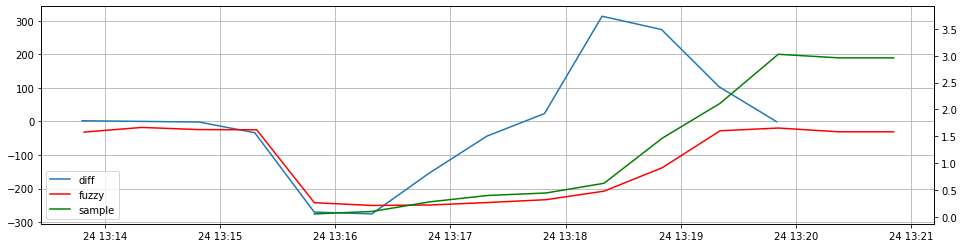

In [177]:
enet_pred_diff_05 = enet_pred_diff(simulation_log_05, pred_05)
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
ln1 = axes.plot(enet_pred_diff_05["date"] + timedelta(seconds=30), enet_pred_diff_05["count"],label='diff')

ax1 = axes.twinx()
ln2 = ax1.plot([date for date in  pred_05[1:]["date"]], pred_05[1:]["pred_fuzzy"], color='red', label="fuzzy")
ln3 = ax1.plot([date for date in  pred_05["date"]], pred_05["pred_sample"], color='green', label="sample")

h1, l1 = axes.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes.legend(h1+h2, l1+l2, loc='lower left')

axes.grid(True)

In [178]:
enet_pred_diff_01

,date,count
0,2022-07-18 12:06:30,-2.482068
1,2022-07-18 12:07:00,4.125286
2,2022-07-18 12:07:30,0.242095
3,2022-07-18 12:08:00,0.041667
4,2022-07-18 12:08:30,-31.191912
5,2022-07-18 12:09:00,-35.818770
6,2022-07-18 12:09:30,-9.227088
7,2022-07-18 12:10:00,-41.319158
8,2022-07-18 12:10:30,2.674780
9,2022-07-18 12:11:00,48.337827


In [179]:
enet_pred_diff_02

,date,count
0,2022-07-18 12:52:26,50.000000
1,2022-07-18 12:52:56,-2.631489
2,2022-07-18 12:53:26,5.398298
3,2022-07-18 12:53:56,-1.233573
4,2022-07-18 12:54:26,-15.147835
5,2022-07-18 12:54:56,-72.604935
6,2022-07-18 12:55:26,-56.685826
7,2022-07-18 12:55:56,-4.467247
8,2022-07-18 12:56:26,-5.448927
9,2022-07-18 12:56:56,9.953022


In [180]:
enet_pred_diff_03

,date,count
0,2022-07-18 13:09:49,7.000000
1,2022-07-18 13:10:19,5.348077
2,2022-07-18 13:10:49,-0.081375
3,2022-07-18 13:11:19,-3.145693
4,2022-07-18 13:11:49,2.451088
5,2022-07-18 13:12:19,-6.171359
6,2022-07-18 13:12:49,-25.023127
7,2022-07-18 13:13:19,-6.756636
8,2022-07-18 13:13:49,-1.289068
9,2022-07-18 13:14:19,12.815823


In [181]:
enet_pred_diff_04

,date,count
0,2022-07-18 14:28:25,-8.903226
1,2022-07-18 14:28:55,7.145161
2,2022-07-18 14:29:25,-4.860578
3,2022-07-18 14:29:55,-10.030494
4,2022-07-18 14:30:25,-155.212981
5,2022-07-18 14:30:55,-140.683558
6,2022-07-18 14:31:25,-49.567274
7,2022-07-18 14:31:55,-22.687934
8,2022-07-18 14:32:25,19.533393
9,2022-07-18 14:32:55,117.241998


In [182]:
enet_pred_diff_05

,date,count
0,2022-07-24 13:13:18,2.014016
1,2022-07-24 13:13:49,0.170291
2,2022-07-24 13:14:19,-1.752376
3,2022-07-24 13:14:48,-33.541488
4,2022-07-24 13:15:19,-270.043951
5,2022-07-24 13:15:49,-275.518971
6,2022-07-24 13:16:19,-153.693241
7,2022-07-24 13:16:49,-43.758095
8,2022-07-24 13:17:19,23.393373
9,2022-07-24 13:17:49,313.418894


In [183]:
pred_01

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18 12:06:30.694938,18.517932,1.552555,1.386294,NaN,NaN,-0.121530
1,0,2022-07-18 12:07:00.717071,22.125286,1.603756,2.197225,NaN,NaN,0.158622
2,0,2022-07-18 12:07:30.702381,22.242095,1.639308,1.832581,NaN,NaN,0.153210
3,0,2022-07-18 12:08:00.723084,20.041667,1.608362,2.079442,NaN,NaN,-0.003312
4,0,2022-07-18 12:08:30.707103,22.808088,1.573876,1.845827,NaN,NaN,0.128233
5,0,2022-07-18 12:09:00.735242,49.181230,1.026570,1.468211,NaN,NaN,0.732982
6,0,2022-07-18 12:09:30.761900,99.772912,0.663783,1.016639,NaN,NaN,0.919359
7,0,2022-07-18 12:10:00.779043,144.680842,0.647976,0.997516,NaN,NaN,0.963697
8,0,2022-07-18 12:10:30.823166,176.674780,0.790734,0.953105,NaN,NaN,0.937334
9,0,2022-07-18 12:11:00.837192,209.337827,0.888360,1.285824,NaN,NaN,0.916167


In [184]:
pred_02

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18 12:52:26.331680,59.000000,1.666667,-inf,NaN,NaN,0.946729
1,0,2022-07-18 12:52:56.360610,21.368511,1.751948,inf,NaN,NaN,-0.014681
2,0,2022-07-18 12:53:26.359121,20.398298,1.734495,inf,NaN,NaN,-0.046612
3,0,2022-07-18 12:53:56.343487,19.766427,1.690061,inf,NaN,NaN,-0.093412
4,0,2022-07-18 12:54:26.353933,19.852165,1.596517,1.897120,NaN,NaN,0.009753
5,0,2022-07-18 12:54:56.361803,21.395065,1.509983,2.484907,NaN,NaN,0.097914
6,0,2022-07-18 12:55:26.397111,84.314174,0.529242,0.525626,NaN,NaN,0.803371
7,0,2022-07-18 12:55:56.421880,183.532753,0.377661,0.301668,NaN,NaN,0.960503
8,0,2022-07-18 12:56:26.464519,268.551073,0.426059,0.619039,NaN,NaN,0.987780
9,0,2022-07-18 12:56:56.524931,336.953022,0.532478,0.870828,NaN,NaN,0.978824


In [185]:
pred_03

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18 13:09:49.518691,23.000000,6.770167,-inf,NaN,NaN,0.027735
1,0,2022-07-18 13:10:19.550555,18.348077,1.652060,-inf,NaN,NaN,-0.145295
2,0,2022-07-18 13:10:49.547064,18.918625,1.670117,inf,NaN,NaN,-0.061211
3,0,2022-07-18 13:11:19.562955,19.854307,1.628426,2.944439,NaN,NaN,0.032234
4,0,2022-07-18 13:11:49.566457,22.451088,1.622697,inf,NaN,NaN,0.210964
5,0,2022-07-18 13:12:19.569844,21.828641,1.613139,3.135494,NaN,NaN,0.121879
6,0,2022-07-18 13:12:49.563577,34.976873,1.217835,1.448815,NaN,NaN,0.603449
7,0,2022-07-18 13:13:19.587089,62.243364,0.842357,1.236763,NaN,NaN,0.866721
8,0,2022-07-18 13:13:49.604554,82.710932,0.871816,1.114361,NaN,NaN,0.911493
9,0,2022-07-18 13:14:19.618074,95.815823,1.088333,1.116961,NaN,NaN,0.874319


In [186]:
pred_04

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-18 14:28:25.342911,20.096774,2.003899,inf,NaN,NaN,-0.006632
1,0,2022-07-18 14:28:55.355040,20.145161,1.707158,inf,NaN,NaN,-0.005864
2,0,2022-07-18 14:29:25.331858,19.139422,1.674627,2.995732,NaN,NaN,-0.092061
3,0,2022-07-18 14:29:55.359276,18.969506,1.625921,3.258097,NaN,NaN,-0.092789
4,0,2022-07-18 14:30:25.362361,22.787019,1.501177,3.610918,NaN,NaN,0.217511
5,0,2022-07-18 14:30:55.428570,130.316442,0.402146,0.329753,NaN,NaN,0.783482
6,0,2022-07-18 14:31:25.429056,333.432726,0.305032,0.105654,NaN,NaN,0.954092
7,0,2022-07-18 14:31:55.630676,507.312066,0.328579,0.395896,NaN,NaN,0.993017
8,0,2022-07-18 14:32:25.591075,623.533393,0.440476,0.688281,NaN,NaN,0.986241
9,0,2022-07-18 14:32:55.698280,756.241998,0.515503,0.730091,NaN,NaN,0.982280


In [187]:
pred_05

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-24 13:13:18.981214,21.014016,1.717682,inf,NaN,NaN,0.046219
1,0,2022-07-24 13:13:49.010016,20.170291,1.577551,inf,NaN,NaN,-0.008969
2,0,2022-07-24 13:14:19.013614,20.247624,1.664635,inf,NaN,NaN,0.007529
3,0,2022-07-24 13:14:48.997227,20.458512,1.624570,3.737670,NaN,NaN,0.006656
4,0,2022-07-24 13:15:19.025221,24.956049,1.620525,inf,NaN,NaN,0.271402
5,0,2022-07-24 13:15:49.067437,241.481029,0.261446,0.052276,NaN,NaN,0.783491
6,0,2022-07-24 13:16:19.171824,634.306759,0.209906,0.098118,NaN,NaN,0.957670
7,0,2022-07-24 13:16:49.489290,1001.241905,0.218633,0.278465,NaN,NaN,0.996777
8,0,2022-07-24 13:17:19.539589,1253.393373,0.265053,0.396608,NaN,NaN,0.995044
9,0,2022-07-24 13:17:49.765531,1500.418894,0.317442,0.442255,NaN,NaN,0.992661


In [188]:
simulation_log_06 = gatling_log_parse("simulation_06.log")
simulation_log_date_06  = simulation_log_06["date"]
simulation_log_count_06 = simulation_log_06["count"]

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3851805739.py:4: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,  delimiter='\t', header=None, names=[ 'c{0:02d}'.format(i) for i in range(10) ])


In [189]:
pred_06 = pd.read_csv("pred_20220725143209.log", names=["index", "date", "max_pred_df_count", "pred_fuzzy", "pred_sample", "pred_fuzzy_300",  "pred_sample_300", "pred_pairwise"])
pred_06

,index,date,max_pred_df_count,pred_fuzzy,pred_sample,pred_fuzzy_300,pred_sample_300,pred_pairwise
0,0,2022-07-25T14:32:10.099624,1413.680000,0.898397,-inf,NaN,NaN,0.349679
1,0,2022-07-25T14:32:40.367717,988.240413,1.324392,inf,NaN,NaN,-0.143938
2,0,2022-07-25T14:33:10.449525,999.047452,1.512812,2.740840,NaN,NaN,-0.010587
3,0,2022-07-25T14:33:40.640937,996.710333,1.561428,2.410799,NaN,NaN,-0.036769
4,0,2022-07-25T14:34:10.828916,997.119404,1.781943,2.154665,NaN,NaN,-0.021411
5,0,2022-07-25T14:34:40.984257,1013.710414,1.760978,2.382628,NaN,NaN,0.161608
6,0,2022-07-25T14:35:11.241843,1058.773197,1.615102,2.397895,NaN,NaN,0.431887
7,0,2022-07-25T14:35:41.441866,1153.975590,1.267854,1.887070,NaN,NaN,0.756847
8,0,2022-07-25T14:36:11.639526,1240.543820,1.084330,1.791759,NaN,NaN,0.871934
9,0,2022-07-25T14:36:41.909084,1305.248929,1.089369,2.498700,NaN,NaN,0.870375


In [190]:
enet_pred_diff_06 = enet_pred_diff(simulation_log_06, pred_06)

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append({"date": d, "count": pred_value - actual}, ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_12606/3838110150.py:9: FutureWarning: The frame

In [191]:
enet_pred_diff_06

,date,count
0,2022-07-25 14:32:10,341.680000
1,2022-07-25 14:32:40,-38.759587
2,2022-07-25 14:33:10,-61.952548
3,2022-07-25 14:33:40,-70.289667
4,2022-07-25 14:34:10,-6.880596
5,2022-07-25 14:34:40,-30.289586
6,2022-07-25 14:35:11,-91.226803
7,2022-07-25 14:35:41,25.975590
8,2022-07-25 14:36:11,-60.456180
9,2022-07-25 14:36:41,45.248929
